In [ ]:
import cv2
import numpy as np
import glob
import os
import pywt
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

In [ ]:
# Function for Wavelet Denoising
def wavelet_denoising(image, wavelet='db1', level=1):
    # Convert image to grayscale if needed
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    coeffs = pywt.wavedec2(image, wavelet, level=level)
    # Zeroing out all detail coefficients (you may want to modify this)
    coeffs_H = list(coeffs)
    coeffs_H[0] *= 1  # Instead of zeroing out, consider applying a threshold
    image_denoised = pywt.waverec2(coeffs_H, wavelet)
    image_denoised = np.clip(image_denoised, 0, 255).astype(np.uint8)
    return image_denoised

In [ ]:
# Function for Adaptive Multi-Scale Retinex (AMSR)
def apply_amsr(image, scales=[150, 190, 110], scale_weights=[1.8, 2, 1.8], gain=50, offset=150):
    img_float = image.astype(np.float32) + 5.0
    retinex = np.zeros_like(img_float)
    for scale, weight in zip(scales, scale_weights):
        blur = cv2.GaussianBlur(img_float, (0, 0), scale)
        retinex += weight * (np.log10(img_float) - np.log10(blur + 1.0))
    retinex = gain * retinex + offset
    retinex = np.clip(retinex, 0, 255).astype(np.uint8)
    return retinex

In [ ]:
# Function to compute PSNR
def calculate_psnr(original, processed):
    mse = np.mean((original.astype(np.float32) - processed.astype(np.float32)) ** 2)
    if mse == 0:
        return float('inf')
    psnr = 20 * np.log10(255.0 / np.sqrt(mse))
    return psnr

In [ ]:
def calculate_ssim(imageA, imageB):
    # Set win_size to 3, and specify channel_axis for color images
    return ssim(imageA, imageB, multichannel=True, win_size=3, channel_axis=-1)

In [ ]:
# Function to display images in 3 columns
def display_images_3col(original, wavelet, wavelet_amsr, title1, title2):
    plt.figure(figsize=(15, 5))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')

    # Wavelet Denoising Image
    plt.subplot(1, 3, 2)
    plt.imshow(wavelet, cmap='gray')  # Ensure grayscale visualization
    plt.title(title1)
    plt.axis('off')

    # Wavelet Denoising + AMSR Image
    plt.subplot(1, 3, 3)
    plt.imshow(wavelet_amsr, cmap='gray')  # Ensure grayscale visualization
    plt.title(title2)
    plt.axis('off')

    plt.show()
    # plt.savefig(title1)

In [ ]:
# Direktori gambar dan output
input_dir = 'C:/kuliah/semester 7/datmin/perbaikan citra/data/'
output_dir = 'C:/kuliah/semester 7/datmin/perbaikan citra/output/'

In [ ]:
# Membuat direktori output jika belum ada
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

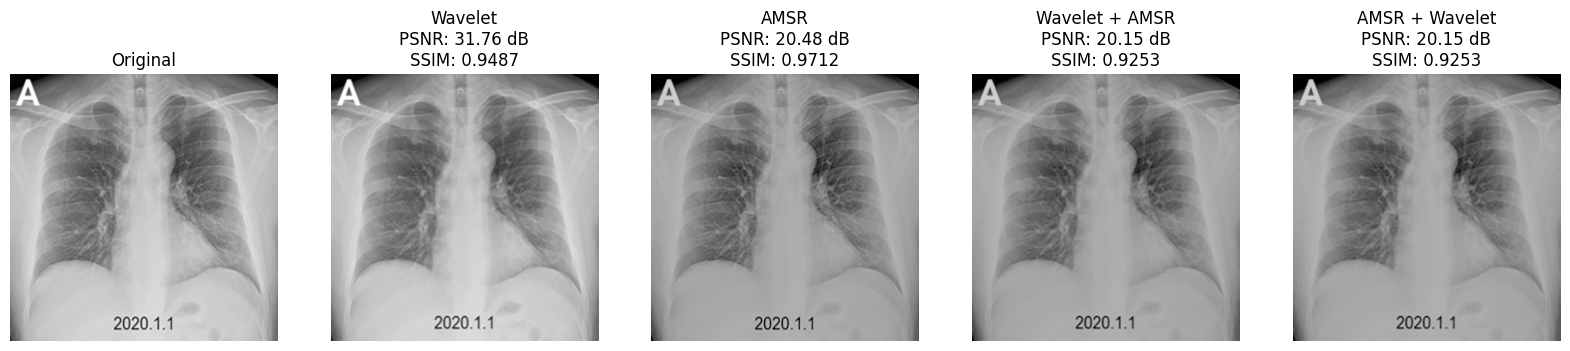

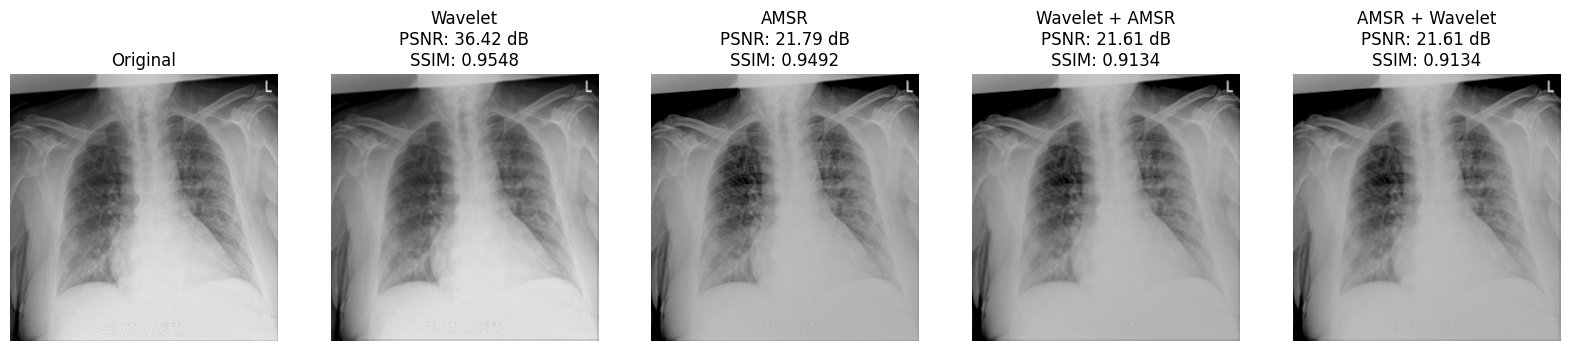

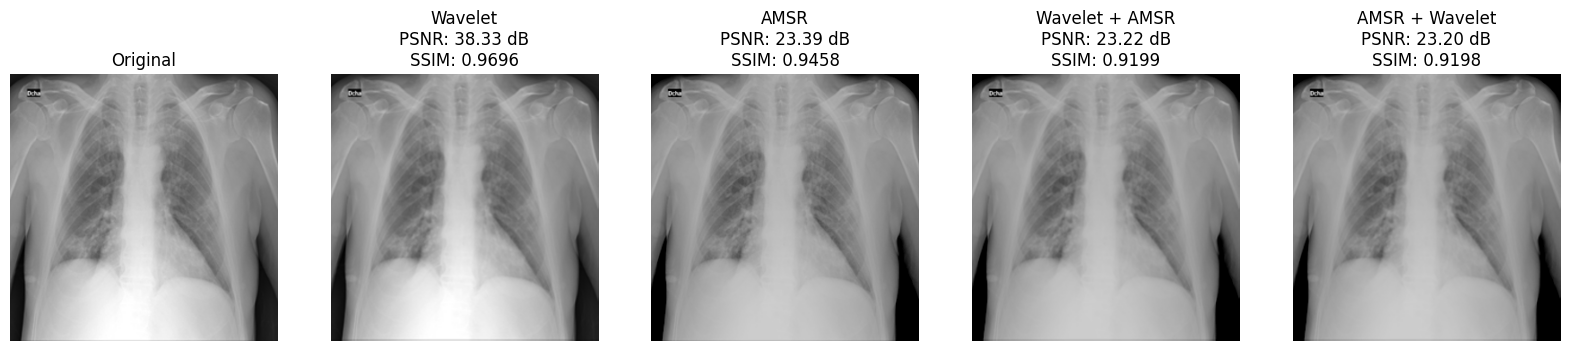

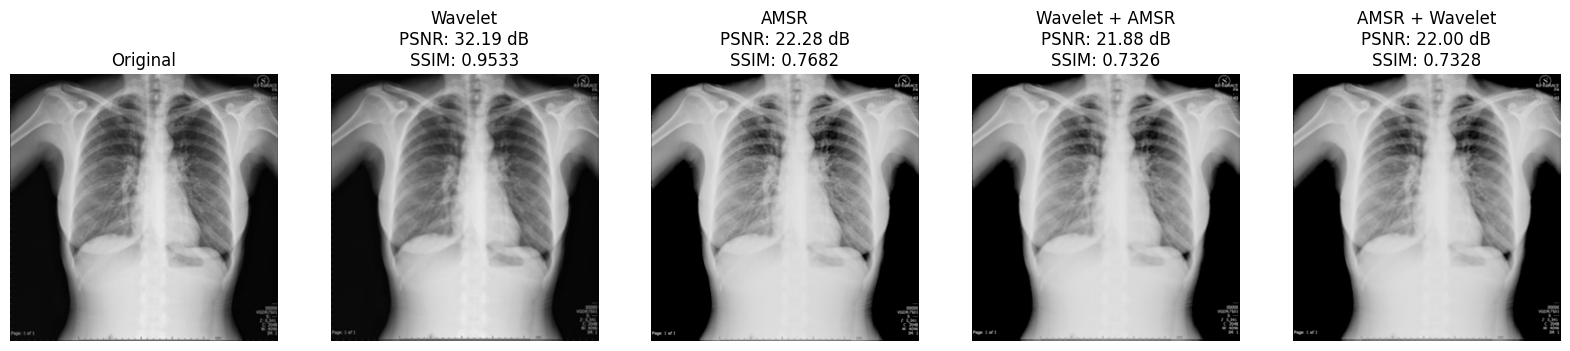

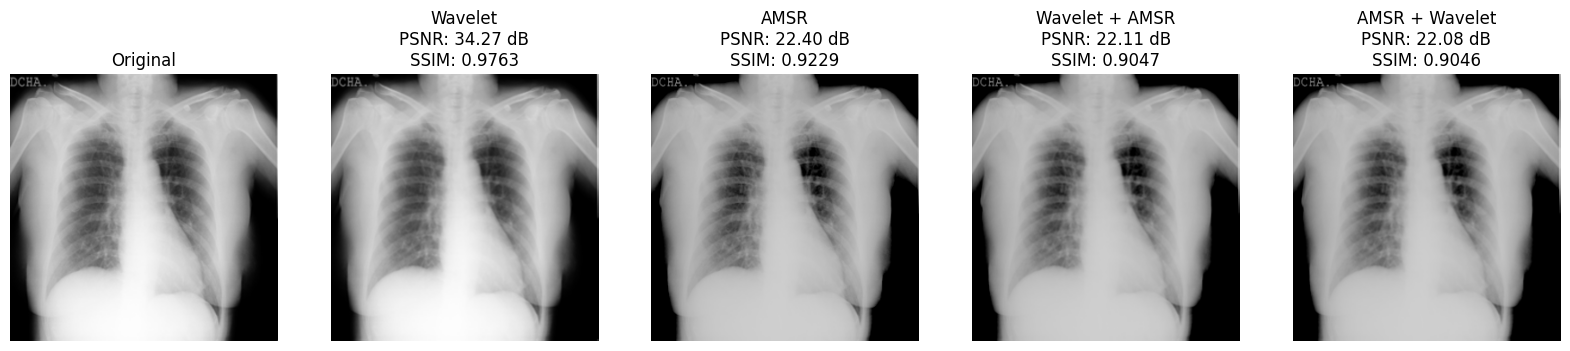

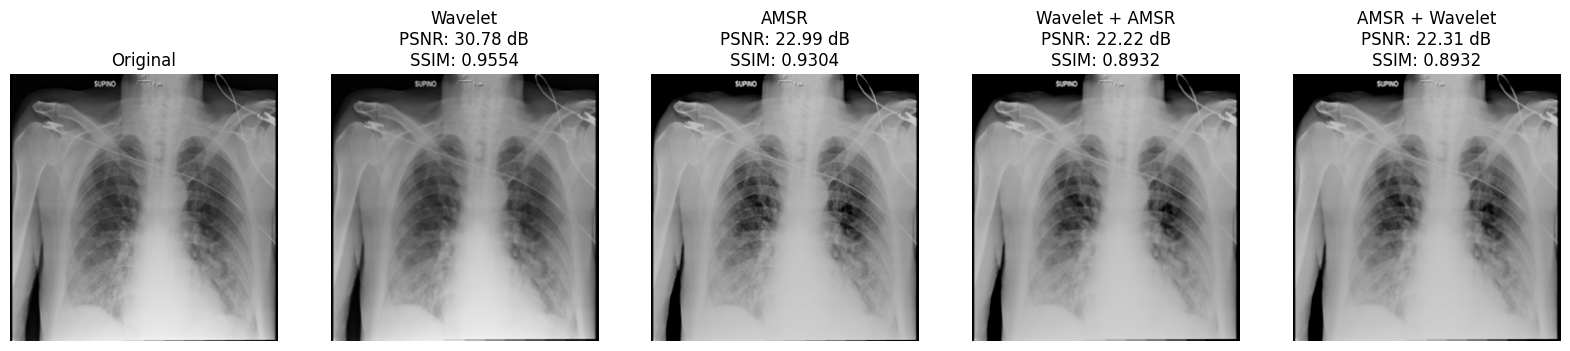

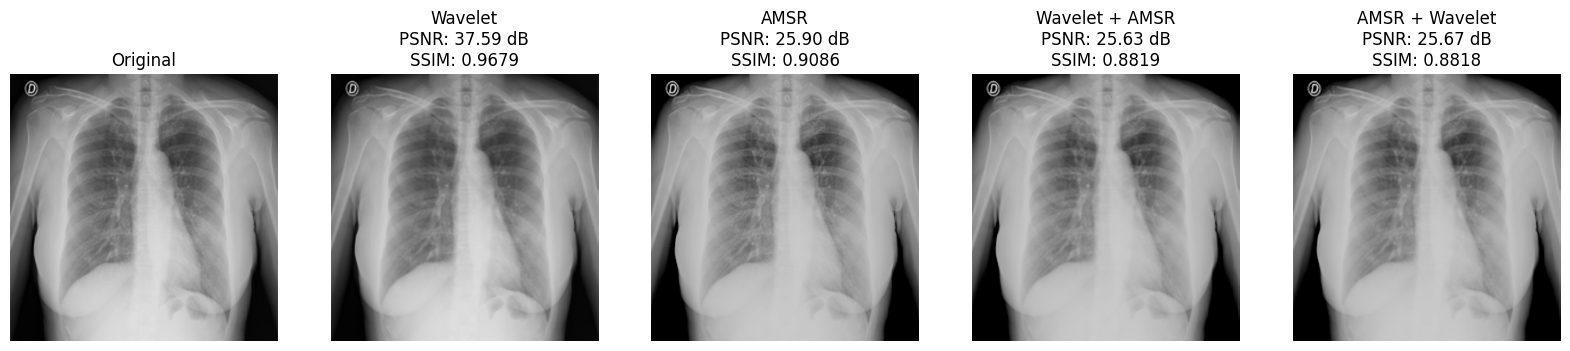

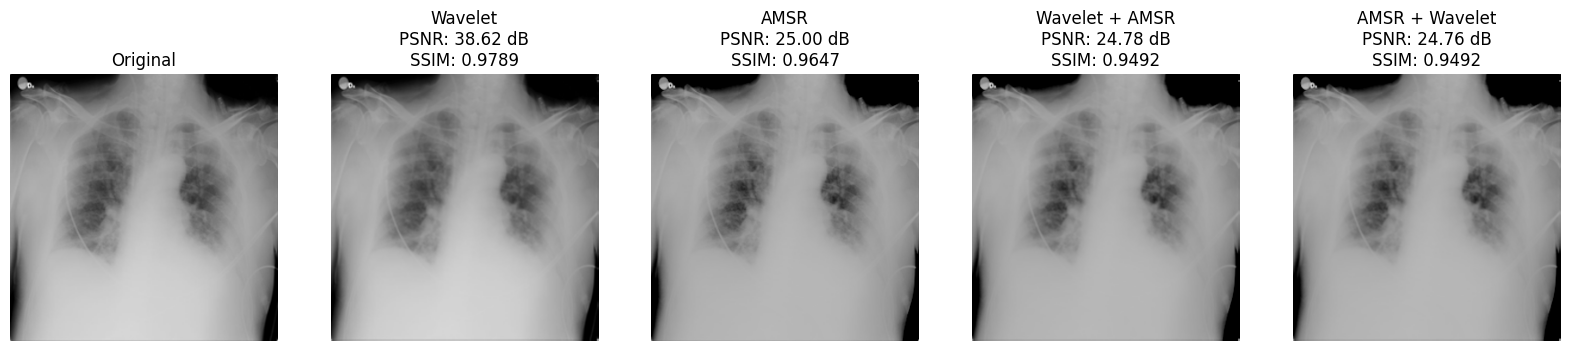

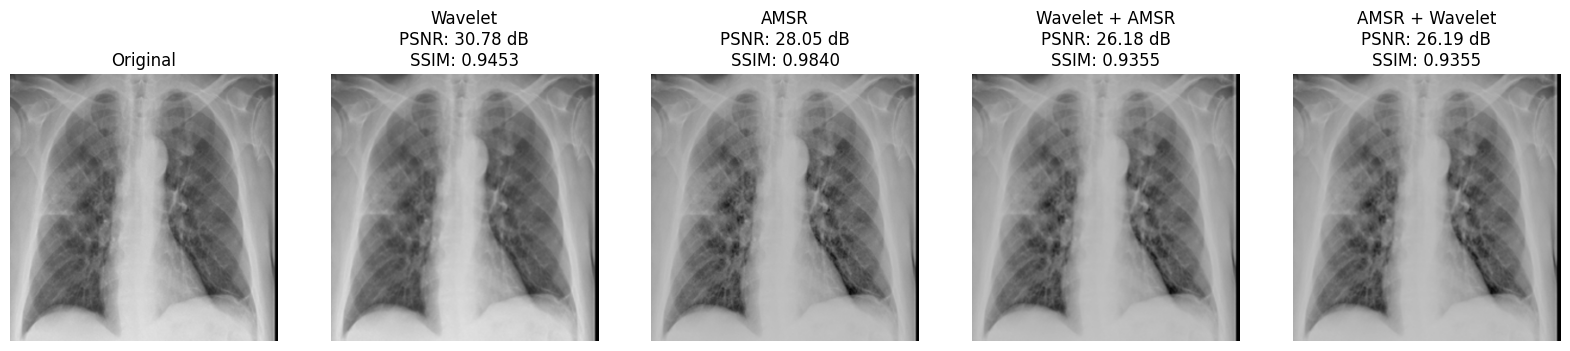

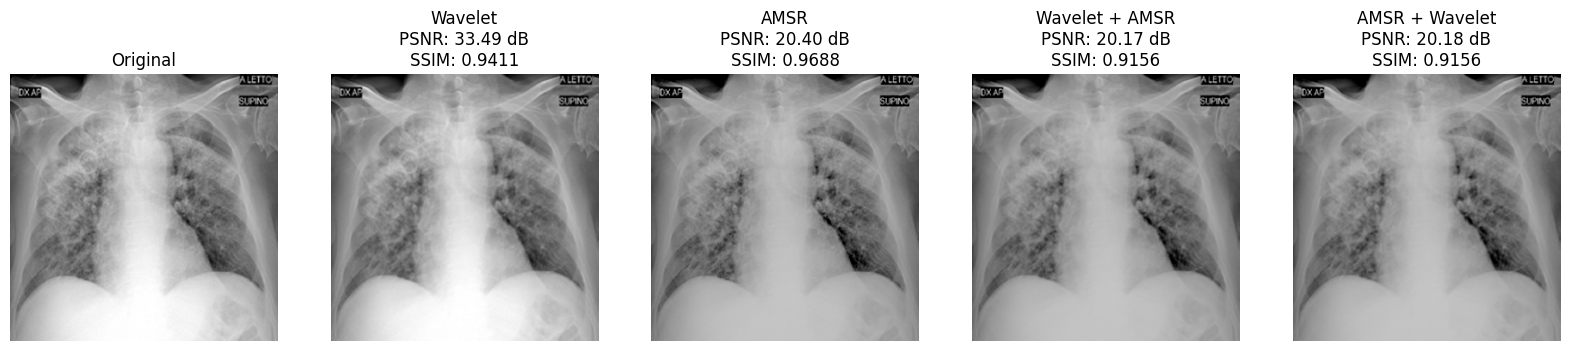

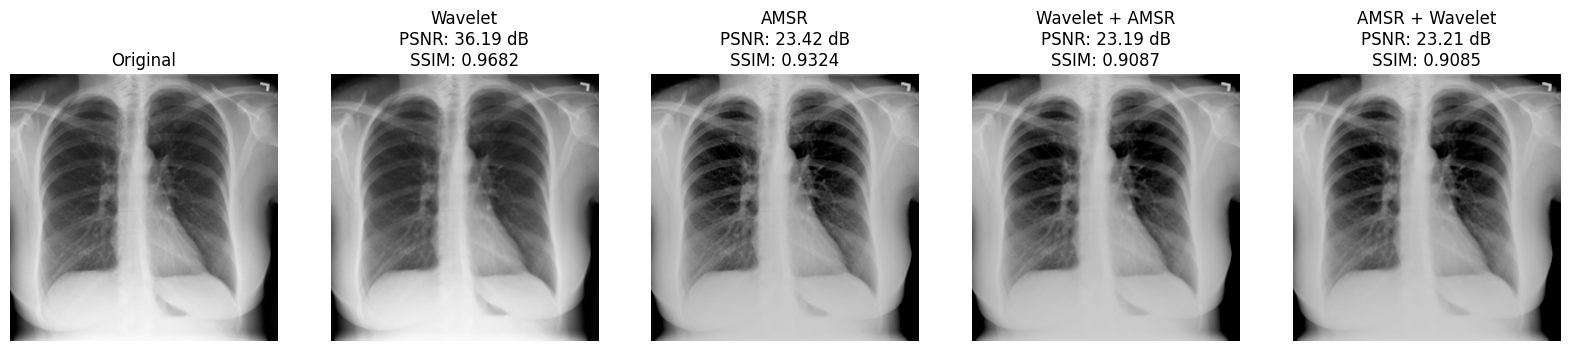

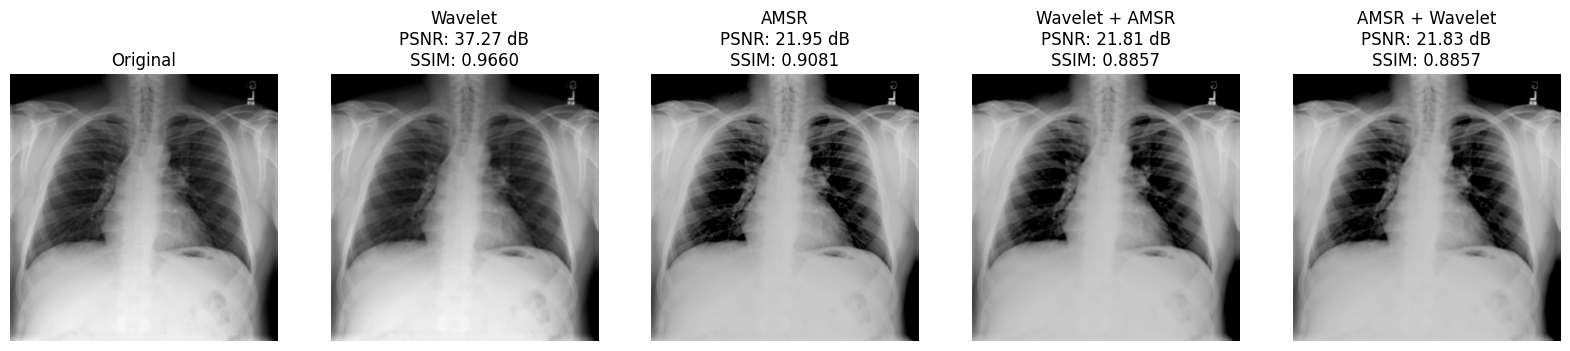

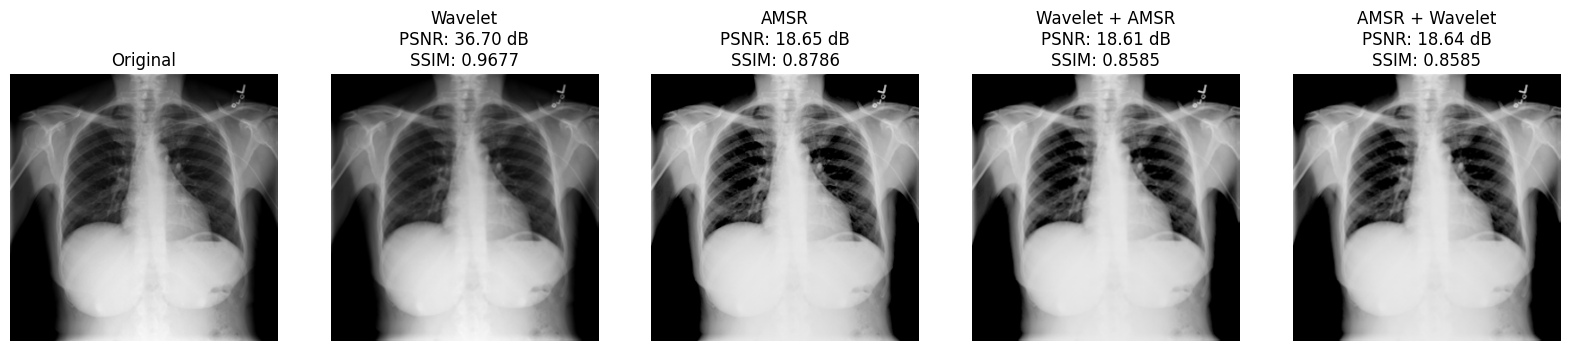

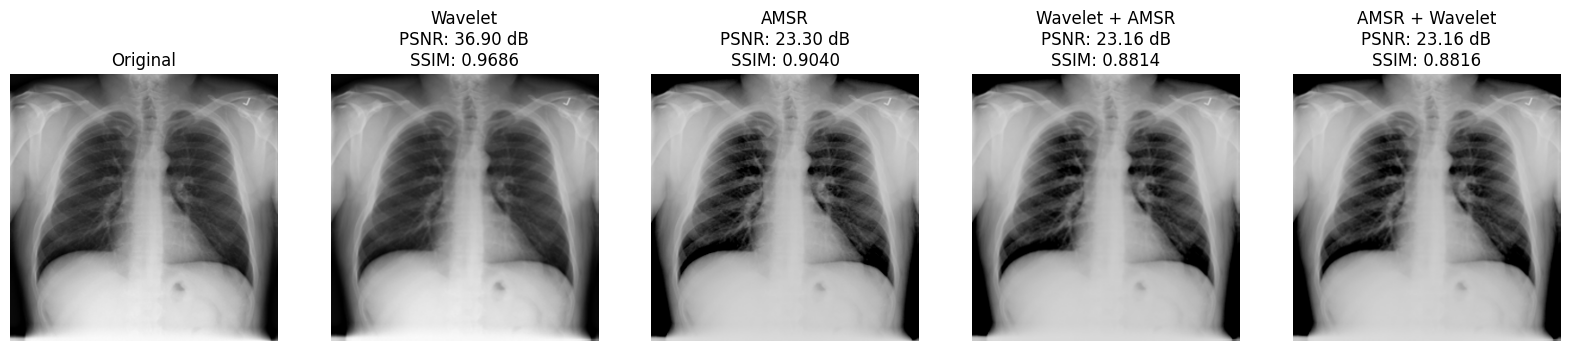

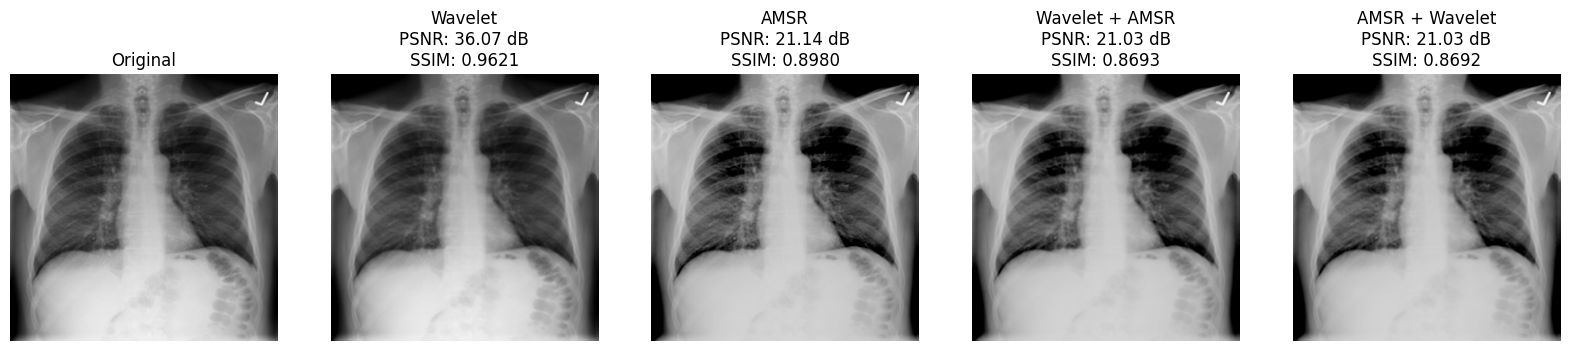

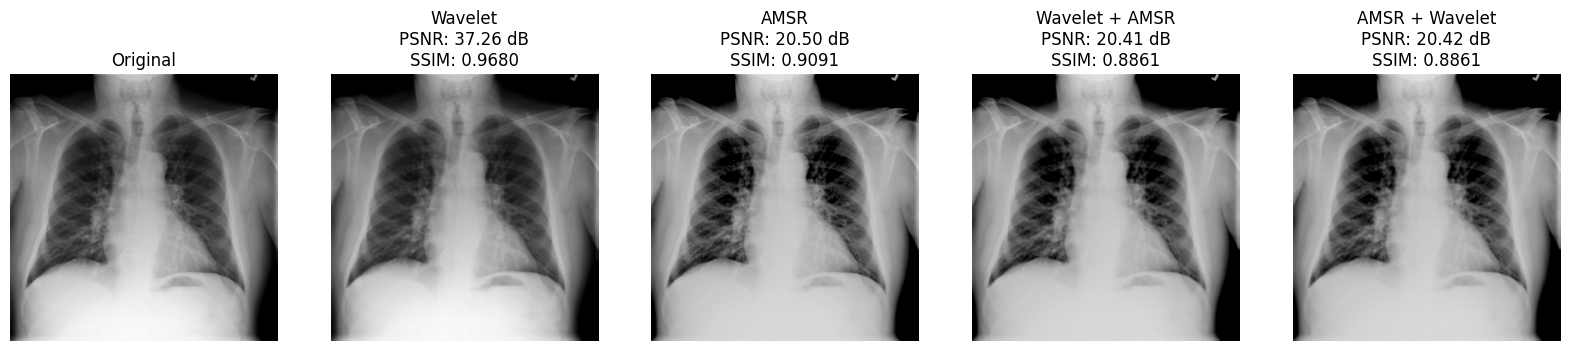

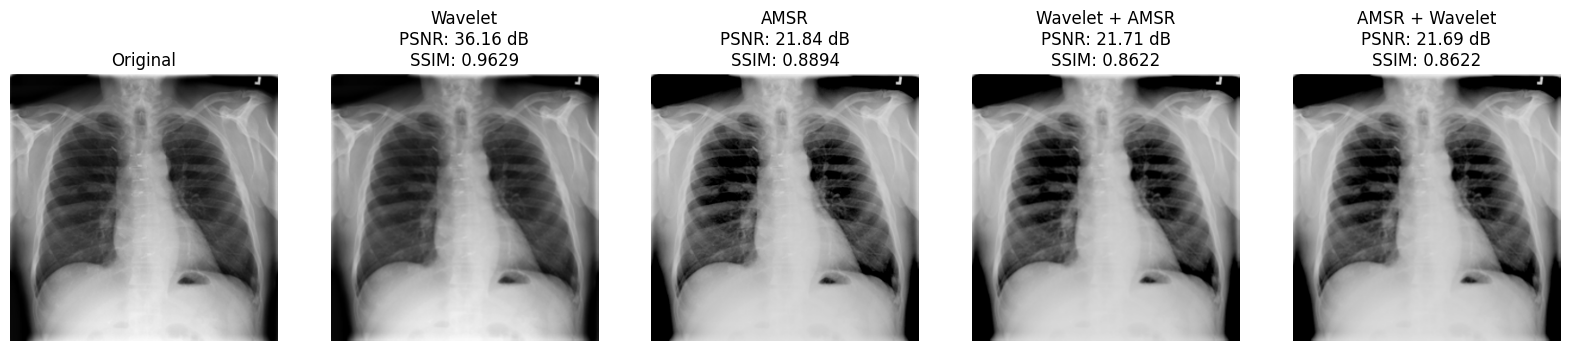

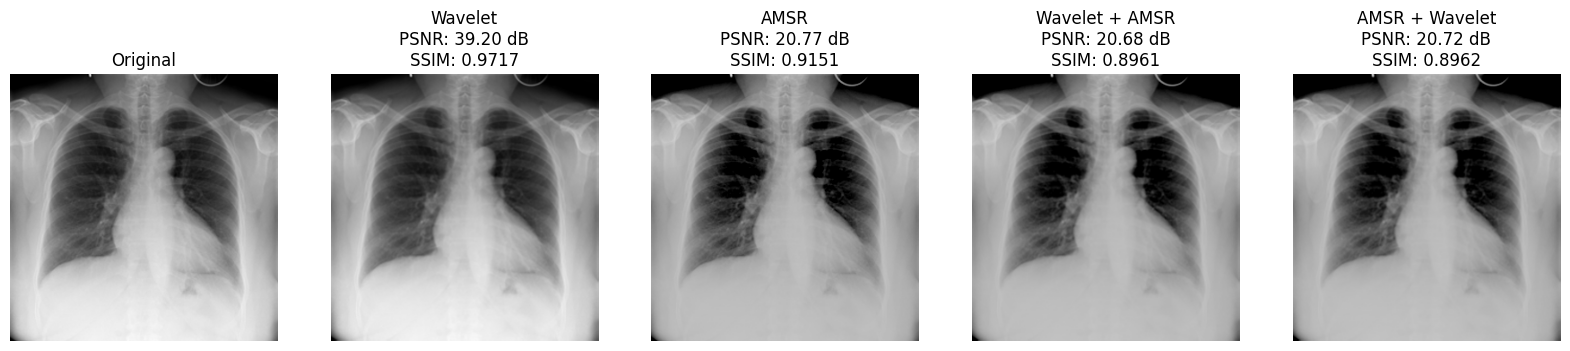

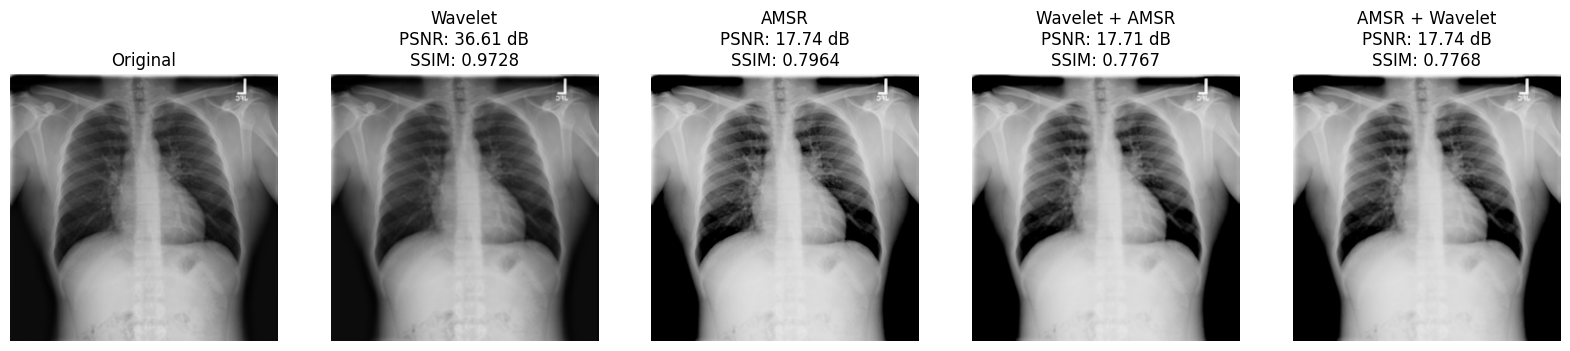

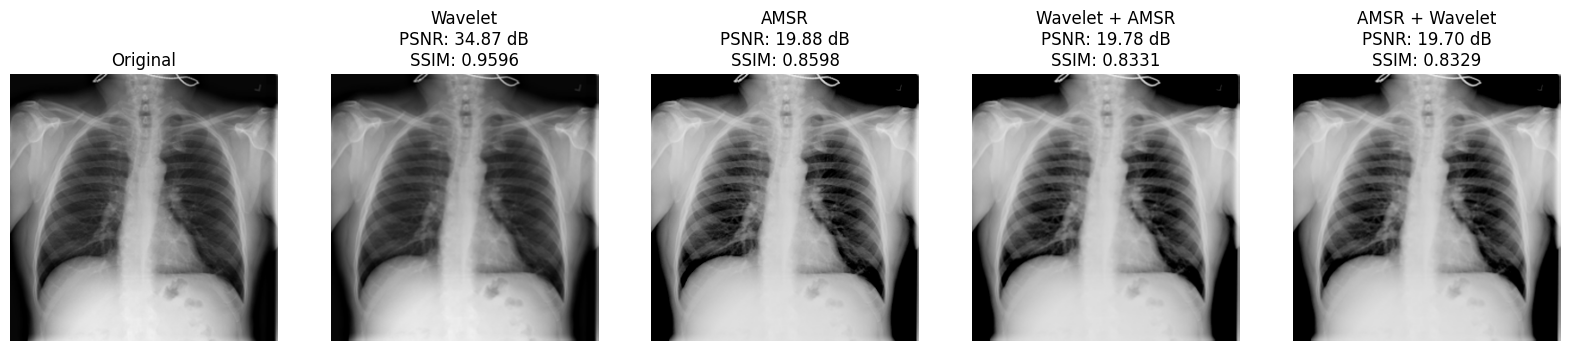

In [ ]:
import os
import glob
import cv2
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt

# Function to calculate SSIM with smaller win_size and specified channel_axis
def calculate_ssim(imageA, imageB):
    # Set win_size to 3, and specify channel_axis for color images
    return ssim(imageA, imageB, multichannel=True, win_size=3, channel_axis=-1)

# Function to display images in 5 columns with titles and metrics
def display_images_5col(original, wavelet, amsr, wavelet_amsr, amsr_wavelet,
                        psnr_w, psnr_a, psnr_wa, psnr_aw,
                        ssim_w, ssim_a, ssim_wa, ssim_aw):
    fig, axes = plt.subplots(1, 5, figsize=(20, 10))

    axes[0].imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Original')
    axes[0].axis('off')

    axes[1].imshow(cv2.cvtColor(wavelet, cv2.COLOR_BGR2RGB))
    axes[1].set_title(f'Wavelet\nPSNR: {psnr_w:.2f} dB\nSSIM: {ssim_w:.4f}')
    axes[1].axis('off')

    axes[2].imshow(cv2.cvtColor(amsr, cv2.COLOR_BGR2RGB))
    axes[2].set_title(f'AMSR\nPSNR: {psnr_a:.2f} dB\nSSIM: {ssim_a:.4f}')
    axes[2].axis('off')

    axes[3].imshow(cv2.cvtColor(wavelet_amsr, cv2.COLOR_BGR2RGB))
    axes[3].set_title(f'Wavelet + AMSR\nPSNR: {psnr_wa:.2f} dB\nSSIM: {ssim_wa:.4f}')
    axes[3].axis('off')

    axes[4].imshow(cv2.cvtColor(amsr_wavelet, cv2.COLOR_BGR2RGB))
    axes[4].set_title(f'AMSR + Wavelet\nPSNR: {psnr_aw:.2f} dB\nSSIM: {ssim_aw:.4f}')
    axes[4].axis('off')

    plt.show()

# Processing each image in the directory
for image_path in glob.glob(os.path.join(input_dir, '*.png')):
    # Read the image
    image = cv2.imread(image_path)

    # Apply Wavelet Denoising
    image_wavelet = wavelet_denoising(image)

    # Apply AMSR directly to the original image
    image_amsr = apply_amsr(image)

    # Apply AMSR to the Wavelet Denoised image
    image_wavelet_amsr = apply_amsr(image_wavelet)

    # Apply Wavelet Denoising to the AMSR image
    image_amsr_wavelet = wavelet_denoising(image_amsr)

    # Resize processed images to match original image size
    image_wavelet = cv2.resize(image_wavelet, (image.shape[1], image.shape[0]))
    image_amsr = cv2.resize(image_amsr, (image.shape[1], image.shape[0]))
    image_wavelet_amsr = cv2.resize(image_wavelet_amsr, (image.shape[1], image.shape[0]))
    image_amsr_wavelet = cv2.resize(image_amsr_wavelet, (image.shape[1], image.shape[0]))

    # Convert processed images to RGB if they are grayscale
    if len(image_wavelet.shape) == 2:
        image_wavelet = cv2.cvtColor(image_wavelet, cv2.COLOR_GRAY2BGR)
    if len(image_amsr.shape) == 2:
        image_amsr = cv2.cvtColor(image_amsr, cv2.COLOR_GRAY2BGR)
    if len(image_wavelet_amsr.shape) == 2:
        image_wavelet_amsr = cv2.cvtColor(image_wavelet_amsr, cv2.COLOR_GRAY2BGR)
    if len(image_amsr_wavelet.shape) == 2:
        image_amsr_wavelet = cv2.cvtColor(image_amsr_wavelet, cv2.COLOR_GRAY2BGR)

    # Save the processed images
    base_name = os.path.basename(image_path)
    cv2.imwrite(os.path.join(output_dir, f'wavelet_{base_name}'), image_wavelet)
    cv2.imwrite(os.path.join(output_dir, f'amsr_{base_name}'), image_amsr)
    cv2.imwrite(os.path.join(output_dir, f'wavelet_amsr_{base_name}'), image_wavelet_amsr)
    cv2.imwrite(os.path.join(output_dir, f'amsr_wavelet_{base_name}'), image_amsr_wavelet)

    # Calculate PSNR and SSIM with the modified SSIM function
    psnr_wavelet = calculate_psnr(image, image_wavelet)
    psnr_amsr = calculate_psnr(image, image_amsr)
    psnr_wavelet_amsr = calculate_psnr(image, image_wavelet_amsr)
    psnr_amsr_wavelet = calculate_psnr(image, image_amsr_wavelet)

    ssim_wavelet = calculate_ssim(image, image_wavelet)
    ssim_amsr = calculate_ssim(image, image_amsr)
    ssim_wavelet_amsr = calculate_ssim(image, image_wavelet_amsr)
    ssim_amsr_wavelet = calculate_ssim(image, image_amsr_wavelet)

    # Display images in 5 columns
    display_images_5col(
        image, image_wavelet, image_amsr, image_wavelet_amsr, image_amsr_wavelet,
        psnr_wavelet, psnr_amsr, psnr_wavelet_amsr, psnr_amsr_wavelet,
        ssim_wavelet, ssim_amsr, ssim_wavelet_amsr, ssim_amsr_wavelet
    )